# Simulation 1 - Benchmarking the Handling the Imputed Data

In [1]:
import os
import sys
import feather
import warnings

import numpy as np # Numerical computing
import pandas as pd # Data manipulatio

import seaborn as sns # R-like high-level plots
import matplotlib.pyplot as plt # Python's base plotting 

sys.path.append('../')
from src import utils, sims, plots, tests

warnings.filterwarnings('ignore')

# Initialize the timer
startTime = utils.getTime()

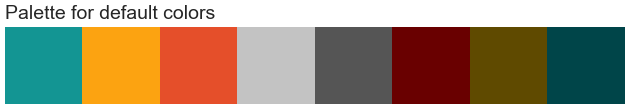

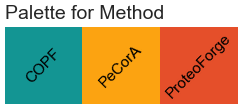

In [2]:
# Create a dictionary for a greyscale color palette with 9 colors
def_colors = [
    "#139593", "#fca311", "#e54f2a",
    "#c3c3c3", "#555555",
    "#690000", "#5f4a00", "#004549"
]
method_palette = {
    "COPF": "#139593",
    "PeCorA": "#fca311",
    "ProteoForge": "#e54f2a",
}
method_styles = {
    "COPF": "--",
    "PeCorA": "-.",
    "ProteoForge": ":",
}
method_markers = {
    "COPF": "o",
    "PeCorA": "s",
    "ProteoForge": "^",
}

# Set seaborn style
sns.set_theme(
    style="white",
    context="paper",
    palette=def_colors,
    font_scale=1,
    rc={
        "figure.figsize": (6, 4),
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial"],
    }
)

# Figure Saving Settings
figure_formats = ["pdf"]
save_to_folder = True
transparet_bg = True
figure_dpi = 300

## Configure dataframe displaying
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 25)

plots.color_palette(
    def_colors, 
    save=False
)
plots.color_palette(
    method_palette, 
    name = "Method",
    save=False
)

In [3]:
notebook_name = "Sim1"
data_path = "./data/generated/"
input_path = "./data/exp/"
output_path = f"./data/exp/{notebook_name}/"
figure_path = f"./figures/{notebook_name}/"

# Create the output folder if it does not exist
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Create figure folder structure, if needed
if save_to_folder:
    for i in figure_formats:
        cur_folder = figure_path + i + "/"
        if not os.path.exists(cur_folder):
            os.makedirs(cur_folder)

# Create the Simulated Data

## Initial Data

### Global Variables for the Simulation


In [4]:
## Global Variables
pthr = 10**-3
cur_method = "WLR"
method_title = "Weighted Least Squares"
formula = 'adjIntensity ~ Condition * allothers'
thresholds = list(utils.generate_thresholds(10.0, -15, 1, 0, 1, 0.1))

# Parameters
seed=42                         # Seed for reproducibility
n_condition = 3                 # Number of conditions (1 is control, others cond-N-1)
n_proteins = 500                # Number of proteins in the dataset
n_replicates = 10               # Number of replicates per condition
n_peptides = (5, 50)            # (min, max) for peptides per protein
condition_shifts = [0, 1, 2]    # Shifts for the conditions
nPro_to_perturb = 250           # Number of proteins to perturb
perturb_conds = ['cond-2']      # Conditions to perturb
perturb_overlap = False         # Allow overlap between perturbed peptides
pertMag_range = (.5, 1.5)       # Range of values to perturb the peptides with (uniform)

### Generate the Simulated Data

In [5]:
# Create Protein Mean Values
mean_values = sims.normal_distribution_with_outliers(
    mu = 20,  
    sd = 2,  
    size = n_proteins, 
    is_log2=False, 
    outlier_fraction=0.10, 
    outlier_sd_multiplier=1.0, 
    seed=seed
)
mean_values = 2**mean_values

# Create Protein CV Values
cv_values = sims.lognormal_distribution(
    mu=10,
    med=8,
    size=n_proteins,
    seed=seed
)

# Generate replicates to have a biological sample as reference
control_data = sims.generate_replicates(
    mean_values, 
    cv_values,
    meanScale="raw",
    cvType="percent", 
    nReps=n_replicates, 
    randomizeCV=True,
    as_dataframe=True, 
    seed=seed
)

# Generate the number of peptides per protein
pepN_cnts = sims.generate_peptide_counts(
    n_proteins=n_proteins,
    min_peptides=n_peptides[0],
    max_peptides=n_peptides[1],
    alpha=.5, 
    beta=3,
)

# Generate the peptide level data using the protein level data 
pep_data = sims.generate_peptide_level(
    control_data,
    pepN_cnts,
    is_log2=False,         
    repStd=(0.1, 0.25),
    outlier_fraction=0.0001,
    outlier_multiplier=0.01,
    add_noise=True,
    noise_sd=0.10,
    seed=seed
)

# Generate Condition Mappers to be utilized later on
condition_sample_map, condition_palette, sample_palette, condition_shifts = sims.generate_condition_mappers(
    n_condition=n_condition-1,
    n_replicates=n_replicates,
    condition_shifts=condition_shifts[1:],
    control_name="control",
    control_color="#8d99ae",
    condition_suffix="cond-",
    condition_palette="Blues",
)

# Generate the complete peptide level data with all conditions
# Copy the peptide data to create the condition data
complete_data = sims.generate_complete_data(
    pep_data,
    condition_shifts=condition_shifts,
    condition_sample_map=condition_sample_map,
    shift_scale=0.10,
    is_log2=False,
    add_noise=False,
    noise_sd=0.10,
    seed=seed
)

unique_proteins = complete_data.reset_index()["Protein"].unique()

# Save the data to a feather file
feather.write_dataframe(complete_data, f"{output_path}simulated_data.feather")

## Creating Perturbed Datasets

### Double Peptide Perturbation

#### The Complete Version of Data

In [6]:
perturb_name = "twoPep"     # Perturbation scenario name
nPep_to_perturb = 2         # Number of peptides to perturb in each protein
np.random.seed(seed)        # Set the seed
simulated_data = feather.read_dataframe(f"{output_path}simulated_data.feather")

# Select random proteins to perturb
proteins_to_perturb = np.random.choice(unique_proteins, nPro_to_perturb, replace=False)
# Subset the data for perturbation
tmp = np.log2(simulated_data).copy()
perturb_data = tmp.loc[proteins_to_perturb]
unchanged_data = tmp.drop(proteins_to_perturb)

perturb_values = sims.generate_perturb_values(
    nPro_to_perturb=nPro_to_perturb,
    nCond=nPep_to_perturb,
    pertMag_range=pertMag_range,
    direction="same",
)

# Find the condition for each protein
perturb_conditions = np.random.choice(perturb_conds, nPro_to_perturb)

# Go through the proteins and perturb single peptide in each
dictCnt = 0
perturbation_map = {}
for i, protein in enumerate(proteins_to_perturb):
    # Get the current protein data
    cur_data = perturb_data.loc[protein]
    # Get the perturbation value
    perturb_value = perturb_values[i]
    # Select n number of non-consecutive peptides to perturb
    pep_pos = np.random.choice(cur_data.index, nPep_to_perturb, replace=False)
    cond = perturb_conditions[i]
    # Get the perturbation condition
    perturb_samples = condition_sample_map[cond]
    for j in range(nPep_to_perturb):
        # Get the peptides to perturb for the current condition
        perturb_peptide = pep_pos[j]
        # Get the perturbation peptide intensity
        perturb_intensity = cur_data.loc[perturb_peptide, perturb_samples]
        # Update the perturbation peptide intensity
        perturb_intensity += perturb_value[j]
        perturb_data.loc[(protein, perturb_peptide), perturb_samples] = perturb_intensity
        perturbation_map[dictCnt] = {
            "Protein": protein,
            "Peptide": perturb_peptide,
            "pertCondition": cond,
            "pertShift": perturb_value[j],
        }
        dictCnt += 1

perturbed_data = pd.concat([perturb_data, unchanged_data], axis=0)
perturbed_data = (np.power(2, perturbed_data))

test_data = sims.build_test_data(
    data=perturbed_data,
    condition_sample_map=condition_sample_map,
    perturbation_map=perturbation_map,
    proteins_to_perturb=proteins_to_perturb,
    missing_data=None,
)

# Save the data
feather.write_dataframe(
    test_data,
    f"{output_path}complete_{perturb_name}_InputData.feather"
)

#### The Imputed Version of Data

In [7]:
# Variables to Modify
missing_data = sims.amputation(
    data = perturbed_data,
    unique_proteins = unique_proteins,
    proteins_to_perturb = proteins_to_perturb,
    condition_shifts = condition_shifts,
    condition_sample_map = condition_sample_map,
    n_amputate_1 = 100,    
    n_amputate_2 = 100,
    n_amputate_3 = 100,
    missing_rate = 0.35,
    seed = seed
)

imputed_data = sims.downshifted_imputation(
    data = missing_data,
    condition_sample_map = condition_sample_map,
    is_log2 = False,
    shiftMag = 2,
    lowPct = 0.15,
    minValue = 8,
    impute_all = False,
    seed = seed
)

test_data = sims.build_test_data(
    data = imputed_data,
    condition_sample_map = condition_sample_map,
    perturbation_map = perturbation_map,
    proteins_to_perturb = proteins_to_perturb,
    missing_data = missing_data,
)

# Save the data
feather.write_dataframe(
    test_data,
    f"{output_path}imputed_{perturb_name}_InputData.feather"
)

#### Running the PeCorA and COPF with Current

In [8]:
# Running PeCorA
!Rscript runPeCorA_Sim1.R {notebook_name} {perturb_name}

Running PeCorA on the simulated data in Sim1 folder with twoPep perturbation.

Working on complete 
[1] "scaling peptides to control == 0"
  |======================================================================| 100%[1] " "
[1] "peptide scaling completed in 10.6 minutes"
[1] "checking which proteins still have at least 2 peptides"
[1] "computing the interaction p-values"
  |======================================================================| 100%[1] " "
[1] "PeCorA finished in 24.72 minutes"
[1] "number of proteins tested = 500"
[1] "number of peptides tested = 5582"
[1] "started making data table"
[1] "correcting p-values"
[1] "number of uncorrelated peptides = 533"
[1] "number of proteins with uncorrelated peptides = 285"
Saving the proteoform results into a feather file... 

Working on imputed 
[1] "scaling peptides to control == 0"
  |======================================================================| 100%[1] " "
[1] "peptide scaling completed in 10.58 minutes"
[1] "checki

In [9]:
# Running COPF
!Rscript runCOPF_Sim1.R {notebook_name} {perturb_name}

Running COPF on the simulated data in Sim1 folder with twoPep perturbation.

Working on complete 
No protein mass annotation found, PCprofiler continues without mass annotation.
Data placed into trace structure from ccprofiler 5583 rows and 4 columns.
Running the clustering... 
Calculating proteoform scores... 
Saving the proteoform results into a feather file... 

Working on imputed 
No protein mass annotation found, PCprofiler continues without mass annotation.
Data placed into trace structure from ccprofiler 5583 rows and 4 columns.
Running the clustering... 
Calculating proteoform scores... 
Saving the proteoform results into a feather file... 
COPF logic run on two versions of the data in 14.53 seconds 


### Half Peptide Perturbation

#### The Complete Version of Data

In [10]:
perturb_name = "halfPep"     # Perturbation scenario name
nPep_to_perturb = 0.5        # Number of peptides to perturb if > 1 then it is a fraction
perturb_dir_setup = "same"   # Randomly perturb the direction of the perturbation [random, same]
np.random.seed(seed)         # Set the seed
simulated_data = feather.read_dataframe(f"{output_path}simulated_data.feather")

# Select random proteins to perturb
proteins_to_perturb = np.random.choice(unique_proteins, nPro_to_perturb, replace=False)
# Subset the data for perturbation
tmp = np.log2(simulated_data).copy()
perturb_data = tmp.loc[proteins_to_perturb]
unchanged_data = tmp.drop(proteins_to_perturb)

# Go through the proteins and perturb single peptide in each
dictCnt = 0
perturbation_map = {}

for i, protein in enumerate(proteins_to_perturb):
    cur_data = perturb_data.loc[protein]
    n = int( np.floor(nPep_to_perturb * len(cur_data) ))
    if n < 2: n = 2
    # print(f"Protein: {protein} - Peptides: {n}, Total Peptides: {len(cur_data)}")
    pepNums = np.random.choice(cur_data.index, n, replace=False)
    # Identify the conditions to perturb
    conds = np.random.choice(perturb_conds, len(pepNums), replace=True)
    # Identify the magnitude of perturbation
    pertMag = np.random.uniform(pertMag_range[0], pertMag_range[1], len(pepNums))
    #
    if perturb_dir_setup == "random":
        pertDir = np.random.choice([-1, 1], len(pepNums), replace=True)
    elif perturb_dir_setup == "same":
        # Pick random direction
        pertDir = np.random.choice([-1, 1], 1, replace=True)
        pertDir = np.repeat(pertDir, len(pepNums))
    
    for j in range(len(pepNums)):
        perturb_samples = condition_sample_map[conds[j]]
        # Get the peptides to perturb for the current condition
        perturb_peptide = pepNums[j]
        # Get the perturbation peptide intensity
        perturb_intensity = cur_data.loc[perturb_peptide, perturb_samples]
        # Update the perturbation peptide intensity
        perturb_intensity += pertMag[j] * pertDir[j]
        perturb_data.loc[(protein, perturb_peptide), perturb_samples] = perturb_intensity
        perturbation_map[dictCnt] = {
            "Protein": protein,
            "Peptide": perturb_peptide,
            "pertCondition": conds[j],
            "pertShift": pertMag[j] * pertDir[j],
        }
        dictCnt += 1

perturbed_data = pd.concat([perturb_data, unchanged_data], axis=0)
perturbed_data = (np.power(2, perturbed_data))

test_data = sims.build_test_data(
    data=perturbed_data,
    condition_sample_map=condition_sample_map,
    perturbation_map=perturbation_map,
    proteins_to_perturb=proteins_to_perturb,
    missing_data=None,
)

# Save the data
feather.write_dataframe(
    test_data,
    f"{output_path}complete_{perturb_name}_InputData.feather"
)

#### The Imputed Version of Data

In [11]:
# Variables to Modify
missing_data = sims.amputation(
    data = perturbed_data,
    unique_proteins = unique_proteins,
    proteins_to_perturb = proteins_to_perturb,
    condition_shifts = condition_shifts,
    condition_sample_map = condition_sample_map,
    n_amputate_1 = 100,    
    n_amputate_2 = 100,
    n_amputate_3 = 100,
    missing_rate = 0.35,
    seed = seed
)

imputed_data = sims.downshifted_imputation(
    data = missing_data,
    condition_sample_map = condition_sample_map,
    is_log2 = False,
    shiftMag = 2,
    lowPct = 0.15,
    minValue = 8,
    impute_all = False,
    seed = seed
)

test_data = sims.build_test_data(
    data = imputed_data,
    condition_sample_map = condition_sample_map,
    perturbation_map = perturbation_map,
    proteins_to_perturb = proteins_to_perturb,
    missing_data = missing_data,
)

# Save the data
feather.write_dataframe(
    test_data,
    f"{output_path}imputed_{perturb_name}_InputData.feather"
)

#### Running the PeCorA and COPF with Current

In [12]:
# Running PeCorA
!Rscript runPeCorA_Sim1.R {notebook_name} {perturb_name}

Running PeCorA on the simulated data in Sim1 folder with halfPep perturbation.

Working on complete 
[1] "scaling peptides to control == 0"
  |======================================================================| 100%[1] " "
[1] "peptide scaling completed in 10.94 minutes"
[1] "checking which proteins still have at least 2 peptides"
[1] "computing the interaction p-values"
  |======================================================================| 100%[1] " "
[1] "PeCorA finished in 24.43 minutes"
[1] "number of proteins tested = 500"
[1] "number of peptides tested = 5582"
[1] "started making data table"
[1] "correcting p-values"
[1] "number of uncorrelated peptides = 1287"
[1] "number of proteins with uncorrelated peptides = 303"
Saving the proteoform results into a feather file... 

Working on imputed 
[1] "scaling peptides to control == 0"
  |======================================================================| 100%[1] " "
[1] "peptide scaling completed in 10.95 minutes"
[1] "che

In [13]:
# Running COPF
!Rscript runCOPF_Sim1.R {notebook_name} {perturb_name}

Running COPF on the simulated data in Sim1 folder with halfPep perturbation.

Working on complete 
No protein mass annotation found, PCprofiler continues without mass annotation.
Data placed into trace structure from ccprofiler 5583 rows and 4 columns.
Running the clustering... 
Calculating proteoform scores... 
Saving the proteoform results into a feather file... 

Working on imputed 
No protein mass annotation found, PCprofiler continues without mass annotation.
Data placed into trace structure from ccprofiler 5583 rows and 4 columns.
Running the clustering... 
Calculating proteoform scores... 
Saving the proteoform results into a feather file... 
COPF logic run on two versions of the data in 14.79 seconds 


### Half Plus Peptide Perturbation

#### The Complete Version of Data

In [14]:
perturb_name = "halfPlusPep" # Perturbation scenario name
nPep_to_perturb = 0.70       # Number of peptides to perturb if > 1 then it is a fraction
perturb_dir_setup = "same"   # Randomly perturb the direction of the perturbation [random, same]
np.random.seed(seed)         # Set the seed
simulated_data = feather.read_dataframe(f"{output_path}simulated_data.feather")

# Select random proteins to perturb
proteins_to_perturb = np.random.choice(unique_proteins, nPro_to_perturb, replace=False)
# Subset the data for perturbation
tmp = np.log2(simulated_data).copy()
perturb_data = tmp.loc[proteins_to_perturb]
unchanged_data = tmp.drop(proteins_to_perturb)

# Go through the proteins and perturb single peptide in each
dictCnt = 0
perturbation_map = {}

for i, protein in enumerate(proteins_to_perturb):
    cur_data = perturb_data.loc[protein]
    n = int( np.ceil(nPep_to_perturb * len(cur_data) ))
    if n < 2: n = 2
    # print(f"Protein: {protein} - Peptides: {n}, Total Peptides: {len(cur_data)}")
    pepNums = np.random.choice(cur_data.index, n, replace=False)
    # Identify the conditions to perturb
    conds = np.random.choice(perturb_conds, len(pepNums), replace=True)
    # Identify the magnitude of perturbation
    pertMag = np.random.uniform(pertMag_range[0], pertMag_range[1], len(pepNums))
    #
    if perturb_dir_setup == "random":
        pertDir = np.random.choice([-1, 1], len(pepNums), replace=True)
    elif perturb_dir_setup == "same":
        # Pick random direction
        pertDir = np.random.choice([-1, 1], 1, replace=True)
        pertDir = np.repeat(pertDir, len(pepNums))
    
    for j in range(len(pepNums)):
        perturb_samples = condition_sample_map[conds[j]]
        # Get the peptides to perturb for the current condition
        perturb_peptide = pepNums[j]
        # Get the perturbation peptide intensity
        perturb_intensity = cur_data.loc[perturb_peptide, perturb_samples]
        # Update the perturbation peptide intensity
        perturb_intensity += pertMag[j] * pertDir[j]
        perturb_data.loc[(protein, perturb_peptide), perturb_samples] = perturb_intensity
        perturbation_map[dictCnt] = {
            "Protein": protein,
            "Peptide": perturb_peptide,
            "pertCondition": conds[j],
            "pertShift": pertMag[j] * pertDir[j],
        }
        dictCnt += 1

perturbed_data = pd.concat([perturb_data, unchanged_data], axis=0)
perturbed_data = (np.power(2, perturbed_data))

test_data = sims.build_test_data(
    data=perturbed_data,
    condition_sample_map=condition_sample_map,
    perturbation_map=perturbation_map,
    proteins_to_perturb=proteins_to_perturb,
    missing_data=None,
)

# Save the data
feather.write_dataframe(
    test_data,
    f"{output_path}complete_{perturb_name}_InputData.feather"
)

#### The Imputed Version of Data

In [15]:
# Variables to Modify
missing_data = sims.amputation(
    data = perturbed_data,
    unique_proteins = unique_proteins,
    proteins_to_perturb = proteins_to_perturb,
    condition_shifts = condition_shifts,
    condition_sample_map = condition_sample_map,
    n_amputate_1 = 100,    
    n_amputate_2 = 100,
    n_amputate_3 = 100,
    missing_rate = 0.35,
    seed = seed
)

imputed_data = sims.downshifted_imputation(
    data = missing_data,
    condition_sample_map = condition_sample_map,
    is_log2 = False,
    shiftMag = 2,
    lowPct = 0.15,
    minValue = 8,
    impute_all = False,
    seed = seed
)

test_data = sims.build_test_data(
    data = imputed_data,
    condition_sample_map = condition_sample_map,
    perturbation_map = perturbation_map,
    proteins_to_perturb = proteins_to_perturb,
    missing_data = missing_data,
)

# Save the data
feather.write_dataframe(
    test_data,
    f"{output_path}imputed_{perturb_name}_InputData.feather"
)

#### Running the PeCorA and COPF with Current

In [16]:
# Running PeCorA
!Rscript runPeCorA_Sim1.R {notebook_name} {perturb_name}

Running PeCorA on the simulated data in Sim1 folder with halfPlusPep perturbation.

Working on complete 
[1] "scaling peptides to control == 0"
  |======================================================================| 100%[1] " "
[1] "peptide scaling completed in 10.87 minutes"
[1] "checking which proteins still have at least 2 peptides"
[1] "computing the interaction p-values"
  |======================================================================| 100%[1] " "
[1] "PeCorA finished in 25.12 minutes"
[1] "number of proteins tested = 500"
[1] "number of peptides tested = 5582"
[1] "started making data table"
[1] "correcting p-values"
[1] "number of uncorrelated peptides = 1285"
[1] "number of proteins with uncorrelated peptides = 303"
Saving the proteoform results into a feather file... 

Working on imputed 
[1] "scaling peptides to control == 0"
  |======================================================================| 100%[1] " "
[1] "peptide scaling completed in 10.83 minutes"
[1] 

In [17]:
# Running COPF
!Rscript runCOPF_Sim1.R {notebook_name} {perturb_name}

Running COPF on the simulated data in Sim1 folder with halfPlusPep perturbation.

Working on complete 
No protein mass annotation found, PCprofiler continues without mass annotation.
Data placed into trace structure from ccprofiler 5583 rows and 4 columns.
Running the clustering... 
Calculating proteoform scores... 
Saving the proteoform results into a feather file... 

Working on imputed 
No protein mass annotation found, PCprofiler continues without mass annotation.
Data placed into trace structure from ccprofiler 5583 rows and 4 columns.
Running the clustering... 
Calculating proteoform scores... 
Saving the proteoform results into a feather file... 
COPF logic run on two versions of the data in 14.69 seconds 


### Random (Up to Half) Peptide Perturbation

#### The Complete Version of Data

In [18]:
perturb_name = "randomPep"   # Perturbation scenario name
nPep_to_perturb = -1        # Number of peptides to perturb if > 1 then it is a fraction
perturb_dir_setup = "same"   # Randomly perturb the direction of the perturbation [random, same]
np.random.seed(seed)         # Set the seed
simulated_data = feather.read_dataframe(f"{output_path}simulated_data.feather")

# Get the unique proteins
unique_proteins = simulated_data.reset_index()["Protein"].unique()
# Select random proteins to perturb
proteins_to_perturb = np.random.choice(unique_proteins, nPro_to_perturb, replace=False)
# Pick a fraction between 0.1 and 0.5 of the peptides to perturb
if nPep_to_perturb == -1:
    nPep_array = np.random.uniform(0.1, 0.5, len(unique_proteins))
elif nPep_to_perturb < 1 and nPep_to_perturb > 0:
    nPep_array = np.repeat(nPep_to_perturb, len(unique_proteins))
elif nPep_to_perturb >= 1:
    nPep_array = np.repeat(nPep_to_perturb, len(unique_proteins))

# Subset the data for perturbation
tmp = np.log2(simulated_data).copy()
perturb_data = tmp.loc[proteins_to_perturb]
unchanged_data = tmp.drop(proteins_to_perturb)

# Go through the proteins and perturb single peptide in each
dictCnt = 0
perturbation_map = {}

for i, protein in enumerate(proteins_to_perturb):
    cur_data = perturb_data.loc[protein]
    if nPep_to_perturb < 1:
        n = int(nPep_array[i] * len(cur_data))
        # Ensure minimum of 1 peptide is perturbed
        if n < 2: n = 2
    elif nPep_to_perturb >= 1:
        n = int(nPep_to_perturb)
    # print(f"Protein: {protein} - Peptides: {n}, Total Peptides: {len(cur_data)}")
    pepNums = np.random.choice(cur_data.index, n, replace=False)
    # Identify the conditions to perturb
    conds = np.random.choice(perturb_conds, len(pepNums), replace=True)
    # Identify the magnitude of perturbation
    pertMag = np.random.uniform(pertMag_range[0], pertMag_range[1], len(pepNums))
    #
    if perturb_dir_setup == "random":
        pertDir = np.random.choice([-1, 1], len(pepNums), replace=True)
    elif perturb_dir_setup == "same":
        # Pick random direction
        pertDir = np.random.choice([-1, 1], 1, replace=True)
        pertDir = np.repeat(pertDir, len(pepNums))
    
    for j in range(len(pepNums)):
        perturb_samples = condition_sample_map[conds[j]]
        # Get the peptides to perturb for the current condition
        perturb_peptide = pepNums[j]
        # Get the perturbation peptide intensity
        perturb_intensity = cur_data.loc[perturb_peptide, perturb_samples]
        # Update the perturbation peptide intensity
        perturb_intensity += pertMag[j] * pertDir[j]
        perturb_data.loc[(protein, perturb_peptide), perturb_samples] = perturb_intensity
        perturbation_map[dictCnt] = {
            "Protein": protein,
            "Peptide": perturb_peptide,
            "pertCondition": conds[j],
            "pertShift": pertMag[j] * pertDir[j],
        }
        dictCnt += 1

perturbed_data = pd.concat([perturb_data, unchanged_data], axis=0)
perturbed_data = (np.power(2, perturbed_data))

test_data = sims.build_test_data(
    data=perturbed_data,
    condition_sample_map=condition_sample_map,
    perturbation_map=perturbation_map,
    proteins_to_perturb=proteins_to_perturb,
    missing_data=None,
)

# Save the data
feather.write_dataframe(
    test_data,
    f"{output_path}complete_{perturb_name}_InputData.feather"
)

#### The Imputed Version of Data

In [19]:
# Variables to Modify
missing_data = sims.amputation(
    data = perturbed_data,
    unique_proteins = unique_proteins,
    proteins_to_perturb = proteins_to_perturb,
    condition_shifts = condition_shifts,
    condition_sample_map = condition_sample_map,
    n_amputate_1 = 100,    
    n_amputate_2 = 100,
    n_amputate_3 = 100,
    missing_rate = 0.35,
    seed = seed
)

imputed_data = sims.downshifted_imputation(
    data = missing_data,
    condition_sample_map = condition_sample_map,
    is_log2 = False,
    shiftMag = 2,
    lowPct = 0.15,
    minValue = 8,
    impute_all = False,
    seed = seed
)

test_data = sims.build_test_data(
    data = imputed_data,
    condition_sample_map = condition_sample_map,
    perturbation_map = perturbation_map,
    proteins_to_perturb = proteins_to_perturb,
    missing_data = missing_data,
)

# Save the data
feather.write_dataframe(
    test_data,
    f"{output_path}imputed_{perturb_name}_InputData.feather"
)

#### Running the PeCorA and COPF with Current

In [20]:
# Running PeCorA
!Rscript runPeCorA_Sim1.R {notebook_name} {perturb_name}

Running PeCorA on the simulated data in Sim1 folder with randomPep perturbation.

Working on complete 
[1] "scaling peptides to control == 0"
  |======================================================================| 100%[1] " "
[1] "peptide scaling completed in 10.79 minutes"
[1] "checking which proteins still have at least 2 peptides"
[1] "computing the interaction p-values"
  |======================================================================| 100%[1] " "
[1] "PeCorA finished in 24.33 minutes"
[1] "number of proteins tested = 500"
[1] "number of peptides tested = 5582"
[1] "started making data table"
[1] "correcting p-values"
[1] "number of uncorrelated peptides = 839"
[1] "number of proteins with uncorrelated peptides = 294"
Saving the proteoform results into a feather file... 

Working on imputed 
[1] "scaling peptides to control == 0"
  |======================================================================| 100%[1] " "
[1] "peptide scaling completed in 11.02 minutes"
[1] "ch

In [21]:
# Running COPF
!Rscript runCOPF_Sim1.R {notebook_name} {perturb_name}

Running COPF on the simulated data in Sim1 folder with randomPep perturbation.

Working on complete 
No protein mass annotation found, PCprofiler continues without mass annotation.
Data placed into trace structure from ccprofiler 5583 rows and 4 columns.
Running the clustering... 
Calculating proteoform scores... 
Saving the proteoform results into a feather file... 

Working on imputed 
No protein mass annotation found, PCprofiler continues without mass annotation.
Data placed into trace structure from ccprofiler 5583 rows and 4 columns.
Running the clustering... 
Calculating proteoform scores... 
Saving the proteoform results into a feather file... 
COPF logic run on two versions of the data in 14.28 seconds 


# Calculating Benchmarkings on Perturbed Datasets

## ProteoForge

In [22]:
save_plots = True
cur_method = 'ProteoForge'
# Collect Results from the simulations 
experiment_mapper = {
    'twoPep': 'Two Peptides', 
    'halfPep': '50% Peptides',
    'halfPlusPep': '>50% Peptides',
    'randomPep': '2>50% Peptides',
}
print(f"Running {cur_method} for the different perturbation scenarios")
for cur_perturb in experiment_mapper.keys():
    print(f" - {experiment_mapper[cur_perturb]} perturbation")
    for dataType in ['complete', 'imputed']:
        print(f"   - {dataType.capitalize()} Version")
        # Load the data
        cur_data = feather.read_dataframe(f"{output_path}{dataType}_{cur_perturb}_InputData.feather")
        ## Run the ProteoForge method
        results = sims.apply_ProteoForge(
            data = cur_data,
            formula = formula,
            protein_col = "Protein",
            peptide_col = "Peptide",
            weight_col = "Weight",
            comparison_col = "allothers",
            correction_method = "fdr"
        )
        # Save the results
        feather.write_dataframe(
            results,
            f"{output_path}{dataType}_{cur_perturb}_{cur_method}_ModelResults.feather"
        )
        
        ## Run the the peptide identification benchmarks
        metricData = utils.create_metric_data(
            results,
            pvalue_thresholds = thresholds,
                label_col="pertPeptide",
                pvalue_col="adj.pval",
        )
        # Save the data
        feather.write_dataframe(
            metricData,
            f"{output_path}{dataType}_{cur_perturb}_{cur_method}_PepIDBenchmarks.feather"
        )
        if save_plots:
            # Plots a WLR Metrics
            _ = plots.combined_curves(
                metricData,
                pthr=pthr,
                prScore='MCC',
                title=f'Peptide Identification Performance of {cur_method} for {dataType.capitalize()} Data with {experiment_mapper[cur_perturb]} Perturbation',
                save = True,
                dont_show = True,
                filename = f"PepIDBenchmarks_{cur_method}_{cur_perturb}_{dataType}",
                filepath = figure_path,
                fileformats = figure_formats,
                dpi = figure_dpi,
                transparent = transparet_bg,
            )
        
        ## Run the protein grouping benchmarks
        metricData = sims.benchmark_ProteoForge_grouping(
            data = results,
            thresholds = thresholds,
            pvalue_col = "adj.pval",
            protein_col = "Protein",
            cluster_col = "cluster_id",
            perturbation_col = "pertPFG",
        )
        # Save the data
        feather.write_dataframe(
            metricData,
            f"{output_path}{dataType}_{cur_perturb}_{cur_method}_PFGBenchmarks.feather"
        )
        if save_plots:
            # Plots a WLR Metrics
            _ = plots.combined_curves(
                metricData,
                pthr=pthr,
                prScore='MCC',
                title=f'Protein Grouping Performance of {cur_method} for {dataType.capitalize()} Data with {experiment_mapper[cur_perturb]} Perturbation',
                save = True,
                dont_show = True,
                filename = f"PFGBenchmarks_{cur_method}_{cur_perturb}_{dataType}",
                filepath = figure_path,
                fileformats = figure_formats,
                dpi = figure_dpi,
                transparent = transparet_bg,
            )

Running ProteoForge for the different perturbation scenarios
 - Two Peptides perturbation
   - Complete Version


   - Imputed Version
 - 50% Peptides perturbation
   - Complete Version
   - Imputed Version
 - >50% Peptides perturbation
   - Complete Version
   - Imputed Version
 - 2>50% Peptides perturbation
   - Complete Version
   - Imputed Version


## PeCorA

### Calculating the Performance Metrics

In [23]:
save_plots = True
cur_method = 'PeCorA'
print(f"Benchmarking {cur_method} for the different perturbation scenarios")
for cur_perturb in experiment_mapper.keys():
    print(f" - {experiment_mapper[cur_perturb]} perturbation")
    for dataType in ['complete', 'imputed']:
        print(f"   - {dataType.capitalize()} Version")
        # Load the data
        results = feather.read_dataframe(f"{output_path}{dataType}_{cur_perturb}_{cur_method}_ModelResults.feather")
        ## Run the the peptide identification benchmarks
        metricData = utils.create_metric_data(
            results,
            pvalue_thresholds = thresholds,
            label_col="pertPeptide",
            pvalue_col="adj_pval",
        )
        # Save the data
        feather.write_dataframe(
            metricData,
            f"{output_path}{dataType}_{cur_perturb}_{cur_method}_PepIDBenchmarks.feather"
        )
        if save_plots:
            # Plots a WLR Metrics
            _ = plots.combined_curves(
                metricData,
                pthr=pthr,
                prScore='MCC',
                title=f'Peptide Identification Performance of {cur_method} for {dataType.capitalize()} Data with {experiment_mapper[cur_perturb]} Perturbation',
                save = True,
                dont_show = True,
                filename = f"PepIDBenchmarks_{cur_method}_{cur_perturb}_{dataType}",
                filepath = figure_path,
                fileformats = figure_formats,
                dpi = figure_dpi,
                transparent = transparet_bg,
            )

Benchmarking PeCorA for the different perturbation scenarios
 - Two Peptides perturbation
   - Complete Version
   - Imputed Version
 - 50% Peptides perturbation
   - Complete Version
   - Imputed Version
 - >50% Peptides perturbation
   - Complete Version
   - Imputed Version
 - 2>50% Peptides perturbation
   - Complete Version
   - Imputed Version


## COPF

### Calculating the Performance Metrics

In [24]:
save_plots = True
cur_method = 'COPF'
# Collect Results from the simulations 
print(f"Benchmarking {cur_method} for the different perturbation scenarios")
for cur_perturb in experiment_mapper.keys():
    print(f" - {experiment_mapper[cur_perturb]} perturbation")
    for dataType in ['complete', 'imputed']:
        print(f"   - {dataType.capitalize()} Version")
        # Load the data
        results = feather.read_dataframe(f"{output_path}{dataType}_{cur_perturb}_{cur_method}_ModelResults.feather")
        # results['cluster'] = results['cluster'].fillna(0).astype(int)
        ## Run the the peptide identification benchmarks
        metricData = utils.create_metric_data(
            results,
            pvalue_thresholds = thresholds,
            label_col="pertPeptide",
            pvalue_col="pval",
        )
        # Save the data
        feather.write_dataframe(
            metricData,
            f"{output_path}{dataType}_{cur_perturb}_{cur_method}_PepIDBenchmarks.feather"
        )
        if save_plots:
            # Plots a WLR Metrics
            _ = plots.combined_curves(
                metricData,
                pthr=pthr,
                prScore='MCC',
                title=f'Peptide Identification Performance of {cur_method} for {dataType.capitalize()} Data with {experiment_mapper[cur_perturb]} Perturbation',
                save = True,
                dont_show = True,
                filename = f"PepIDBenchmarks_{cur_method}_{cur_perturb}_{dataType}",
                filepath = figure_path,
                fileformats = figure_formats,
                dpi = figure_dpi,
                transparent = transparet_bg,
            )

        ## Run the protein grouping benchmarks
        metricData = sims.benchmark_COPF_grouping(
            data = results,
            thresholds = thresholds,
            pvalue_col = "pval",
            protein_col = "Protein",
            cluster_col = "cluster",
            perturbation_col = "pertPFG",
        )
        # Save the data
        feather.write_dataframe(
            metricData,
            f"{output_path}{dataType}_{cur_perturb}_{cur_method}_PFGBenchmarks.feather"
        )
        if save_plots:
            # Plots a WLR Metrics
            _ = plots.combined_curves(
                metricData,
                pthr=pthr,
                prScore='MCC',
                title=f'Protein Grouping Performance of {cur_method} for {dataType.capitalize()} Data with {experiment_mapper[cur_perturb]} Perturbation',
                save = True,
                dont_show = True,
                filename = f"PFGBenchmarks_{cur_method}_{cur_perturb}_{dataType}",
                filepath = figure_path,
                fileformats = figure_formats,
                dpi = figure_dpi,
                transparent = transparet_bg,
            )

Benchmarking COPF for the different perturbation scenarios
 - Two Peptides perturbation
   - Complete Version
   - Imputed Version
 - 50% Peptides perturbation
   - Complete Version
   - Imputed Version
 - >50% Peptides perturbation
   - Complete Version
   - Imputed Version
 - 2>50% Peptides perturbation
   - Complete Version
   - Imputed Version


# Benchmark the Simulation Together 

## Put together the Benchmark Data

In [25]:
from importlib import reload
reload(tests)
reload(plots)
reload(utils)
reload(sims);

In [34]:
id_benchmark_name = "PepIDBenchmarks.feather"
grp_benchmark_name = "PFGBenchmarks.feather"
# Load the benchmark data
idBenchmarkData = pd.DataFrame()
grpBenchmarkData = pd.DataFrame()
dataTypes = ['complete', 'imputed']
methods = ["COPF", "PeCorA", "ProteoForge"]
for dataType in dataTypes:
    for curMethod in methods:
        for cur_perturb in experiment_mapper.keys():
            if cur_perturb == 'onePep': continue 
            cur_path = f"{output_path}{dataType}_{cur_perturb}_{curMethod}_{id_benchmark_name}"
            cur_data = feather.read_dataframe(cur_path).assign(
                Method=curMethod,
                Experiment=experiment_mapper[cur_perturb],
                DataType=dataType
            )
            idBenchmarkData = pd.concat([idBenchmarkData, cur_data], ignore_index=True)
            if curMethod == "PeCorA":
                continue
            else:
                cur_path = f"{output_path}{dataType}_{cur_perturb}_{curMethod}_{grp_benchmark_name}"
                cur_data = feather.read_dataframe(cur_path).assign(
                    Method=curMethod,
                    Experiment=experiment_mapper[cur_perturb],
                    DataType=dataType
                )
                grpBenchmarkData = pd.concat([grpBenchmarkData, cur_data], ignore_index=True)


print(f"Identification Benchmark Data shape: {idBenchmarkData.shape}")
idBenchmarkData['Experiment'] = pd.Categorical(
    idBenchmarkData['Experiment'], 
    categories=list(experiment_mapper.values()), 
    ordered=True
)
print(f"Grouping Benchmark Data shape: {grpBenchmarkData.shape}")
grpBenchmarkData['Experiment'] = pd.Categorical(
    grpBenchmarkData['Experiment'], 
    categories=list(experiment_mapper.values()), 
    ordered=True
)

Identification Benchmark Data shape: (600, 15)
Grouping Benchmark Data shape: (400, 15)


## Peptide Identification 

### ROC Curves with AUC Scores

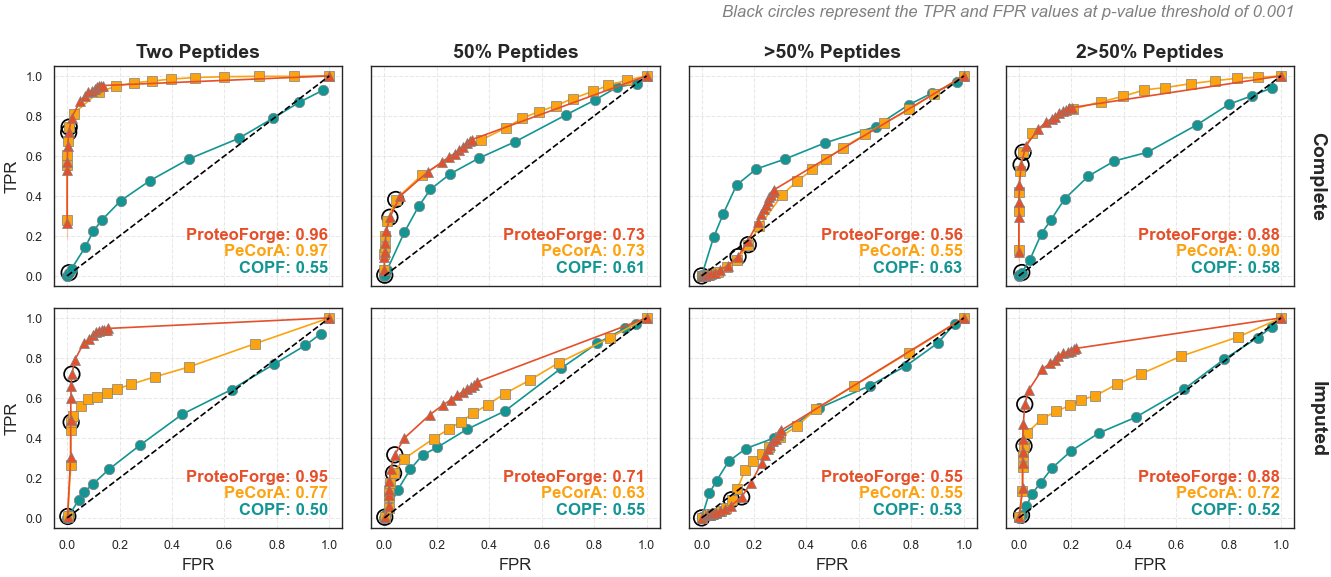

In [36]:
# ROC Curves for different perturbations and methods
fig, axes = plt.subplots(
    2, 4, figsize=(16, 6), 
    sharey=True, sharex=True,
    gridspec_kw={
        "wspace": 0.1, 
        "hspace": 0.1
    }
)

for i, pert in enumerate(idBenchmarkData['Experiment'].unique()):
    for j, dataType in enumerate(dataTypes):
        cur_data = idBenchmarkData[
            (idBenchmarkData["Experiment"] == pert) & 
            (idBenchmarkData["DataType"] == dataType)
        ]
        # Calculate AUC per method from TPR and FPR
        auc_data = cur_data.groupby("Method").apply(
            lambda x: np.trapz(x.sort_values("FPR")["TPR"], x.sort_values("FPR")["FPR"])
        )
        # Plot the ROC curve
        sns.lineplot(
            data=cur_data,
            x="FPR",
            y="TPR",
            hue="Method",
            style="Method",
            palette=method_palette,
            ax=axes[j, i],
            # Show the points
            markers=method_markers,
            dashes=False,
            markersize=7.5,
            markeredgewidth=0.5,
            markeredgecolor="gray", 
            legend=False,
            rasterized=True 
        )
        # Add AUC values as legend like text
        for k, method in enumerate(auc_data.index):
            auc = auc_data[method]
            # Add color to match the palette
            color = method_palette[method]
            axes[j, i].text(
                0.95,
                0.05 + k * 0.075,
                f"{method}: {auc:.2f}",
                color=color,
                transform=axes[j, i].transAxes,
                ha="right",
                va="bottom",
                fontsize=12,
                fontweight="bold",
            )
            # Add a large no-facecolor marker to the pthr value for each method
            pthr_data = cur_data[(cur_data["Method"] == method) & (cur_data["threshold"] == pthr)]
            axes[j, i].scatter(
                pthr_data["FPR"],
                pthr_data["TPR"],
                color=color,
                s=125,
                edgecolor="black",
                linewidth=1.25,
                marker="o",
                facecolors="none",
            )
        
        # Add the diagonal line
        axes[j, i].plot([0, 1], [0, 1], color="black", linestyle="--")
        # axes[j, i].set_title(f"{pert}", fontsize=14, fontweight="bold")
        axes[j, i].set_xlabel("FPR", fontsize=12)
        axes[j, i].set_ylabel("TPR", fontsize=12)
        axes[j, i].set_xlim(-0.05, 1.05)
        axes[j, i].set_ylim(-0.05, 1.05)
        axes[j, i].grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")
        # If top row set the title
        if j == 0:
            axes[j, i].set_title(f"{pert}", fontsize=14, fontweight="bold")
        # For the last column, set the text for the dataType on the right
        if i == 3:
            axes[j, i].text(
                1.05,
                0.5,
                f"{dataType.capitalize()}",
                transform=axes[j, i].transAxes,
                ha="left",
                va="center",
                fontsize=14,
                fontweight="bold",
                rotation=270,
            )

# Add a text indicating the circle is the p-value threshold under fig.title and above the first subplot
fig.text(
    0.9,
    .97,
    f"Black circles represent the TPR and FPR values at p-value threshold of {pthr}",
    ha="right",
    va="center",
    fontsize=12,
    fontstyle="italic",
    color="gray",
)

# Finalize the plot
plt.tight_layout()

# Save the figure, if save_to_folder is True
if save_to_folder:
    plots.save_figures(
        fig_obj = plt.gcf(),
        filename = f"IdentificationBenchmark_ROC_AUC",
        filepath = figure_path,
        fileformat = figure_formats,
        dpi = figure_dpi,
        transparent = transparet_bg
    )

### Precision-Recall Curves with Maximum MCC Scores

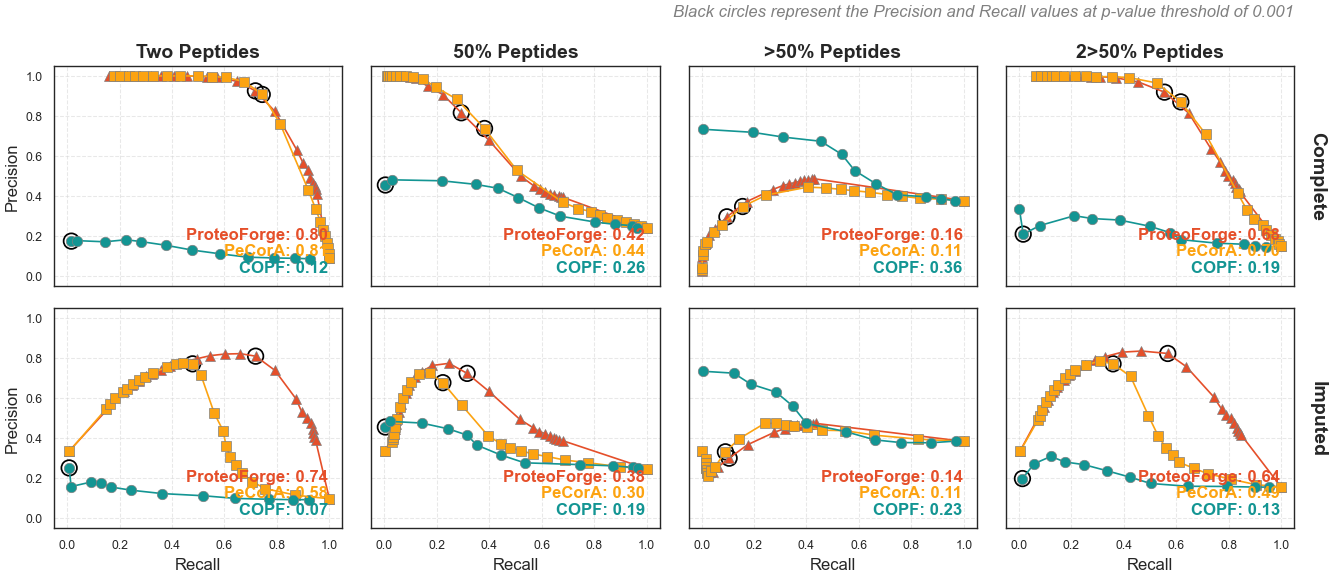

In [37]:
## Precision-Recall Curves for different perturbations and methods
fig, axes = plt.subplots(
    2, 4, figsize=(16, 6), 
    sharey=True, sharex=True,
    gridspec_kw={
        "wspace": 0.1, 
        "hspace": 0.1
    }
)

for i, pert in enumerate(idBenchmarkData['Experiment'].unique()):
    for j, dataType in enumerate(dataTypes):
        cur_data = idBenchmarkData[
            (idBenchmarkData["Experiment"] == pert) & 
            (idBenchmarkData["DataType"] == dataType)
        ]
        cur_data = cur_data.sort_values("Recall", ascending=False)
        cur_data = cur_data[~((cur_data["Recall"] == 0) & (cur_data["Precision"] == 0))]
        
        mcc_data = cur_data.groupby("Method")['MCC'].max()

        # Plot the ROC curve
        sns.lineplot(
            data=cur_data,
            x="Recall",
            y="Precision",
            hue="Method",
            style="Method",
            palette=method_palette,
            ax=axes[j, i],
            # Show the points
            markers=method_markers,
            dashes=False,
            markersize=7.5,
            markeredgewidth=0.5,
            markeredgecolor="gray", 
            legend=False,
            rasterized=True 
        )
        # Add AUC values as legend like text
        for k, method in enumerate(mcc_data.index):
            score = mcc_data[method]
            # Add color to match the palette
            color = method_palette[method]
            axes[j, i].text(
                0.95,
                0.05 + k * 0.075,
                f"{method}: {score:.2f}",
                color=color,
                transform=axes[j, i].transAxes,
                ha="right",
                va="bottom",
                fontsize=12,
                fontweight="bold",
            )
            # Add a large no-facecolor marker to the pthr value for each method
            pthr_data = cur_data[(cur_data["Method"] == method) & (cur_data["threshold"] == pthr)]
            axes[j, i].scatter(
                pthr_data["Recall"],
                pthr_data["Precision"],
                color=color,
                s=125,
                edgecolor="black",
                linewidth=1.25,
                marker="o",
                facecolors="none",
            )
        
        # axes[j, i].set_title(f"{pert}", fontsize=14, fontweight="bold")
        axes[j, i].set_xlabel("Recall", fontsize=12)
        axes[j, i].set_ylabel("Precision", fontsize=12)
        axes[j, i].set_xlim(-0.05, 1.05)
        axes[j, i].set_ylim(-0.05, 1.05)
        axes[j, i].grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")
        # If top row set the title
        if j == 0:
            axes[j, i].set_title(f"{pert}", fontsize=14, fontweight="bold")
        # For the last column, set the text for the dataType on the right
        if i == 3:
            axes[j, i].text(
                1.05,
                0.5,
                f"{dataType.capitalize()}",
                transform=axes[j, i].transAxes,
                ha="left",
                va="center",
                fontsize=14,
                fontweight="bold",
                rotation=270,
            )
# Add a text indicating the circle is the p-value threshold under fig.title and above the first subplot
fig.text(
    0.9,
    .97,
    f"Black circles represent the Precision and Recall values at p-value threshold of {pthr}",
    ha="right",
    va="center",
    fontsize=12,
    fontstyle="italic",
    color="gray",
)
# Finalize the plot
plt.tight_layout()

# Save the figure, if save_to_folder is True
if save_to_folder:
    plots.save_figures(
        fig_obj = plt.gcf(),
        filename = f"IdentificationBenchmark_PR_MCC",
        filepath = figure_path,
        fileformat = figure_formats,
        dpi = figure_dpi,
        transparent = transparet_bg
    )

### MCC over Adj.P-Value Thresholds

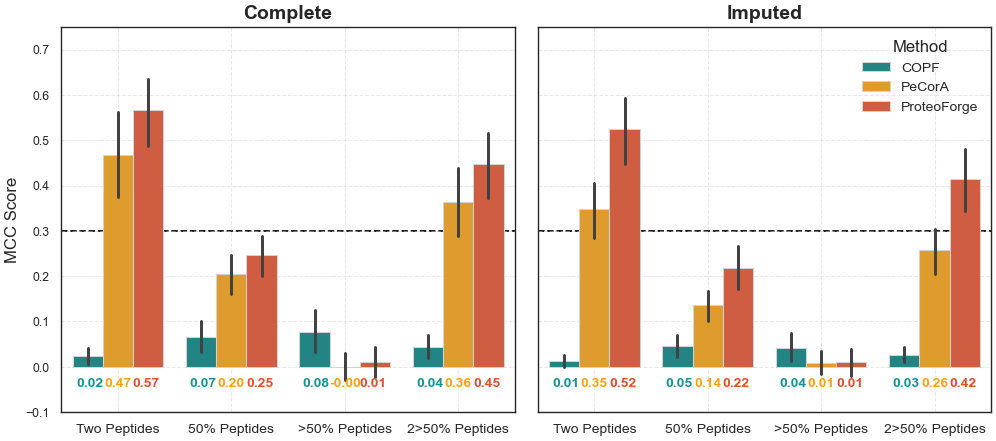

In [38]:
# # MCC Score for different perturbations and methods at the best threshold

# Create subplots for MCC Score for different perturbations and methods at the best threshold
fig, axes = plt.subplots(
    1, 2, figsize=(12, 5), 
    sharey=True, sharex=True,
    gridspec_kw={"wspace": 0.05, "hspace": 0.1}
)

for i, dataType in enumerate(dataTypes):
    cur_data = idBenchmarkData[idBenchmarkData["DataType"] == dataType]
    sns.barplot(
        ax=axes[i],
        data=cur_data,
        x="Experiment",
        y="MCC",
        hue="Method",
        # errorbar=('se', 0.95),
        palette=method_palette,
        edgecolor="lightgrey",
        linewidth=0.75,
    )
    # Write the average MCC score for each method on the top of the bars
    for j, pert in enumerate(idBenchmarkData['Experiment'].unique()):
        for k, method in enumerate(["COPF", "PeCorA", "ProteoForge"]):
            cur_score = cur_data[
                (cur_data["Experiment"] == pert) & 
                (cur_data["Method"] == method)
            ]["MCC"].mean()
            axes[i].text(
                j + k * 0.25 - 0.25,
                0 - 0.05,
                f"{cur_score:.2f}",
                color=method_palette[method],
                ha="center",
                va="bottom",
                fontsize=10,
                fontweight="bold",
            )

            
    axes[i].set_title(f"{dataType.capitalize()}", fontsize=14, fontweight="bold")
    axes[i].set_xlabel('')
    axes[i].set_ylim(-0.1, .75)
    axes[i].axhline(0.3, color="black", linestyle="--", linewidth=1.25, zorder=0)
    axes[i].grid("y", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=0, ha="center", fontsize=10)
    # If first subplot, set the ylabel
    if i == 0:
        axes[i].set_ylabel("MCC Score", fontsize=12)
        # Remove the legend for the first subplot
        axes[i].legend().set_visible(False)

    else:
        axes[i].set_ylabel("")
        axes[i].legend(loc='upper right', title="Method", fontsize=10, title_fontsize=12, frameon=False)
plt.tight_layout()

# Save the figure, if save_to_folder is True
if save_to_folder:
    plots.save_figures(
        fig_obj=plt.gcf(),
        filename=f"IdentificationBenchmark_MCCBarplot",
        filepath=figure_path,
        fileformat=figure_formats,
        dpi=figure_dpi,
        transparent=transparet_bg
    )

## Proteoform Grouping

### ROC Curves with AUC Scores

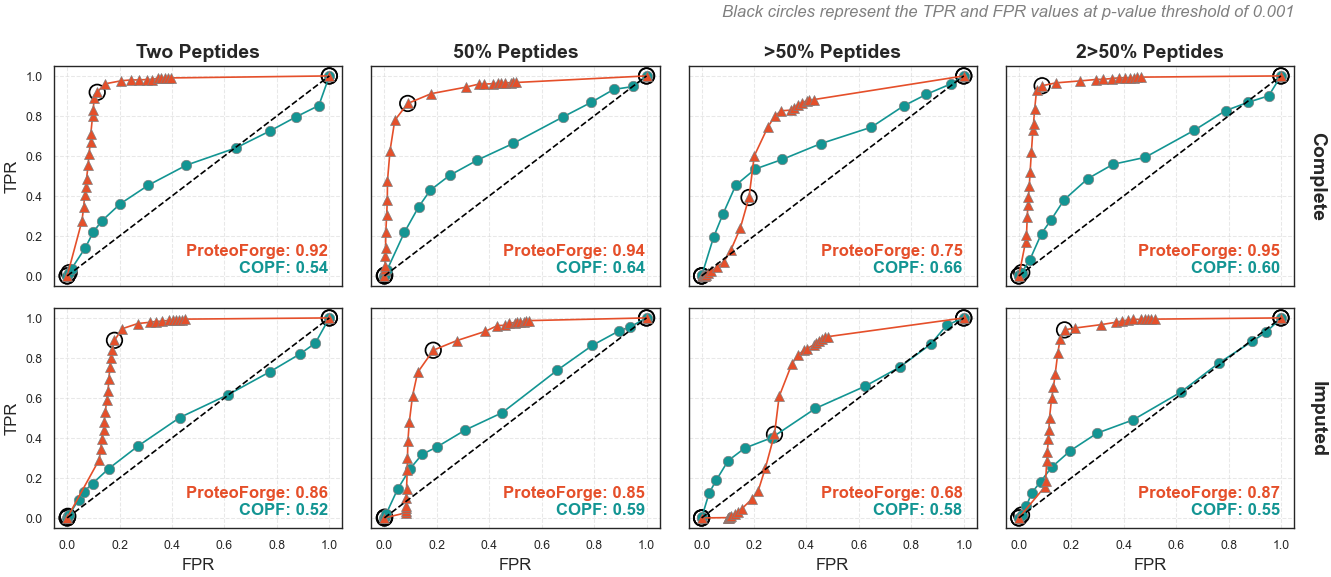

In [39]:
## ROC Curves for different perturbations and methods
fig, axes = plt.subplots(
    2, 4, figsize=(16, 6), 
    sharey=True, sharex=True,
    gridspec_kw={
        "wspace": 0.1, 
        "hspace": 0.1
    }
)

for i, pert in enumerate(idBenchmarkData['Experiment'].unique()):
    for j, dataType in enumerate(dataTypes):
        cur_data = grpBenchmarkData[
            (grpBenchmarkData["Experiment"] == pert) & 
            (grpBenchmarkData["DataType"] == dataType)
        ]
        # Add 0,0 and 1,1 points to the data for each Method, Experiment and DataType
        for method in cur_data["Method"].unique():
            for threshold in thresholds:
                cur_data = pd.concat([
                    cur_data,
                    pd.DataFrame([{
                        "Method": method,
                        "Experiment": pert,
                        "DataType": dataType,
                        "threshold": threshold,
                        "TPR": 0,
                        "FPR": 0,
                    }, {
                        "Method": method,
                        "Experiment": pert,
                        "DataType": dataType,
                        "threshold": threshold,
                        "TPR": 1,
                        "FPR": 1,
                    }])
                ], ignore_index=True)
        # Calculate AUC per method from TPR and FPR
        auc_data = cur_data.groupby("Method").apply(
            lambda x: np.trapz(x.sort_values("FPR")["TPR"], x.sort_values("FPR")["FPR"])
        )
        # Plot the ROC curve
        sns.lineplot(
            data=cur_data,
            x="FPR",
            y="TPR",
            hue="Method",
            style="Method",
            palette=method_palette,
            ax=axes[j, i],
            # Show the points
            markers=method_markers,
            dashes=False,
            markersize=7.5,
            markeredgewidth=0.5,
            markeredgecolor="gray", 
            legend=False,
            rasterized=True 
        )
        # Add AUC values as legend like text
        for k, method in enumerate(auc_data.index):
            auc = auc_data[method]
            # Add color to match the palette
            color = method_palette[method]
            axes[j, i].text(
                0.95,
                0.05 + k * 0.075,
                f"{method}: {auc:.2f}",
                color=color,
                transform=axes[j, i].transAxes,
                ha="right",
                va="bottom",
                fontsize=12,
                fontweight="bold",
            )
            # Add a large no-facecolor marker to the pthr value for each method
            pthr_data = cur_data[(cur_data["Method"] == method) & (cur_data["threshold"] == pthr)]
            axes[j, i].scatter(
                pthr_data["FPR"],
                pthr_data["TPR"],
                color=color,
                s=125,
                edgecolor="black",
                linewidth=1.25,
                marker="o",
                facecolors="none",
            )
        
        # Add the diagonal line
        axes[j, i].plot([0, 1], [0, 1], color="black", linestyle="--")
        # axes[j, i].set_title(f"{pert}", fontsize=14, fontweight="bold")
        axes[j, i].set_xlabel("FPR", fontsize=12)
        axes[j, i].set_ylabel("TPR", fontsize=12)
        axes[j, i].set_xlim(-0.05, 1.05)
        axes[j, i].set_ylim(-0.05, 1.05)
        axes[j, i].grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")
        # If top row set the title
        if j == 0:
            axes[j, i].set_title(f"{pert}", fontsize=14, fontweight="bold")
        # For the last column, set the text for the dataType on the right
        if i == 3:
            axes[j, i].text(
                1.05,
                0.5,
                f"{dataType.capitalize()}",
                transform=axes[j, i].transAxes,
                ha="left",
                va="center",
                fontsize=14,
                fontweight="bold",
                rotation=270,
            )

# Add a text indicating the circle is the p-value threshold under fig.title and above the first subplot
fig.text(
    0.9,
    .97,
    f"Black circles represent the TPR and FPR values at p-value threshold of {pthr}",
    ha="right",
    va="center",
    fontsize=12,
    fontstyle="italic",
    color="gray",
)

# Finalize the plot
plt.tight_layout()

# Save the figure, if save_to_folder is True
if save_to_folder:
    plots.save_figures(
        fig_obj = plt.gcf(),
        filename = f"GroupingBenchmark_ROC_AUC",
        filepath = figure_path,
        fileformat = figure_formats,
        dpi = figure_dpi,
        transparent = transparet_bg
    )


### Precision-Recall Curves with Maximum MCC Scores

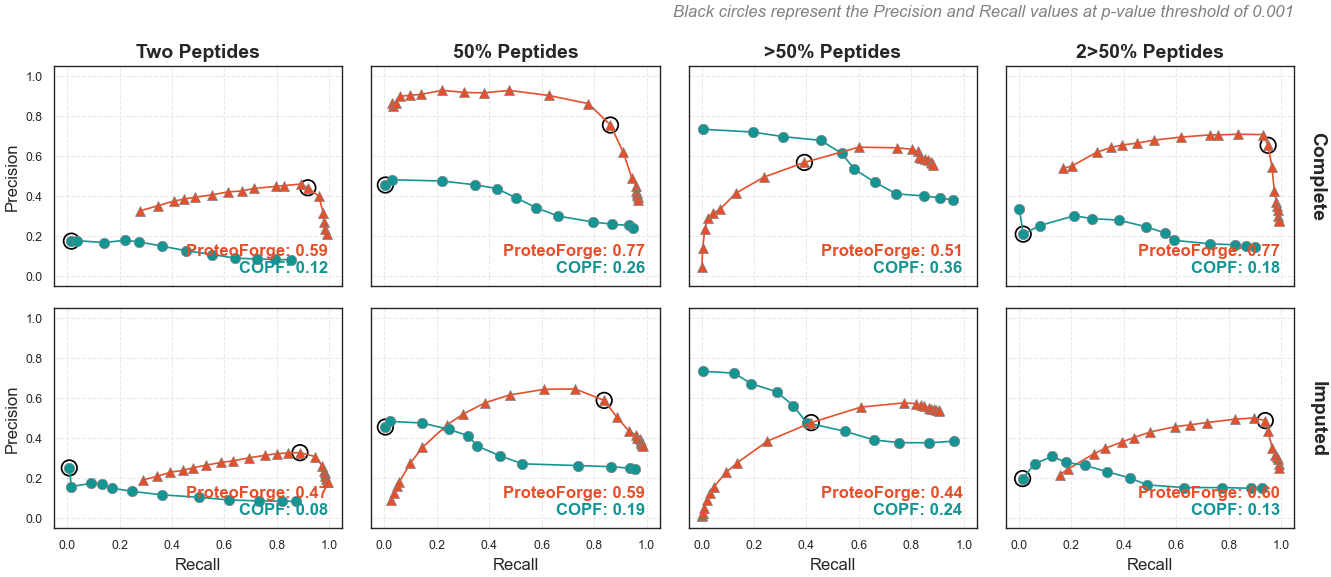

In [40]:
# Precision-Recall Curves for different perturbations and methods
fig, axes = plt.subplots(
    2, 4, figsize=(16, 6), 
    sharey=True, sharex=True,
    gridspec_kw={
        "wspace": 0.1, 
        "hspace": 0.1
    }
)

for i, pert in enumerate(grpBenchmarkData['Experiment'].unique()):
    for j, dataType in enumerate(dataTypes):
        cur_data = grpBenchmarkData[
            (grpBenchmarkData["Experiment"] == pert) & 
            (grpBenchmarkData["DataType"] == dataType)
        ]
        cur_data = cur_data.sort_values("Recall", ascending=False)
        cur_data = cur_data[~((cur_data["Recall"] == 0) & (cur_data["Precision"] == 0))]
        
        mcc_data = cur_data.groupby("Method")['MCC'].max()

        # Plot the ROC curve
        sns.lineplot(
            data=cur_data,
            x="Recall",
            y="Precision",
            hue="Method",
            style="Method",
            palette=method_palette,
            ax=axes[j, i],
            # Show the points
            markers=method_markers,
            dashes=False,
            markersize=7.5,
            markeredgewidth=0.5,
            markeredgecolor="gray", 
            legend=False,
            rasterized=True 
        )
        # Add AUC values as legend like text
        for k, method in enumerate(mcc_data.index):
            score = mcc_data[method]
            # Add color to match the palette
            color = method_palette[method]
            axes[j, i].text(
                0.95,
                0.05 + k * 0.075,
                f"{method}: {score:.2f}",
                color=color,
                transform=axes[j, i].transAxes,
                ha="right",
                va="bottom",
                fontsize=12,
                fontweight="bold",
            )
            # Add a large no-facecolor marker to the pthr value for each method
            pthr_data = cur_data[(cur_data["Method"] == method) & (cur_data["threshold"] == pthr)]
            axes[j, i].scatter(
                pthr_data["Recall"],
                pthr_data["Precision"],
                color=color,
                s=125,
                edgecolor="black",
                linewidth=1.25,
                marker="o",
                facecolors="none",
            )
        
        # axes[j, i].set_title(f"{pert}", fontsize=14, fontweight="bold")
        axes[j, i].set_xlabel("Recall", fontsize=12)
        axes[j, i].set_ylabel("Precision", fontsize=12)
        axes[j, i].set_xlim(-0.05, 1.05)
        axes[j, i].set_ylim(-0.05, 1.05)
        axes[j, i].grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")
        # If top row set the title
        if j == 0:
            axes[j, i].set_title(f"{pert}", fontsize=14, fontweight="bold")
        # For the last column, set the text for the dataType on the right
        if i == 3:
            axes[j, i].text(
                1.05,
                0.5,
                f"{dataType.capitalize()}",
                transform=axes[j, i].transAxes,
                ha="left",
                va="center",
                fontsize=14,
                fontweight="bold",
                rotation=270,
            )
# Add a text indicating the circle is the p-value threshold under fig.title and above the first subplot
fig.text(
    0.9,
    .97,
    f"Black circles represent the Precision and Recall values at p-value threshold of {pthr}",
    ha="right",
    va="center",
    fontsize=12,
    fontstyle="italic",
    color="gray",
)
# Finalize the plot
plt.tight_layout()

# Save the figure, if save_to_folder is True
if save_to_folder:
    plots.save_figures(
        fig_obj = plt.gcf(),
        filename = f"GroupingBenchmark_PR_MCC",
        filepath = figure_path,
        fileformat = figure_formats,
        dpi = figure_dpi,
        transparent = transparet_bg
    )

### MCC over Adj.P-Value Thresholds

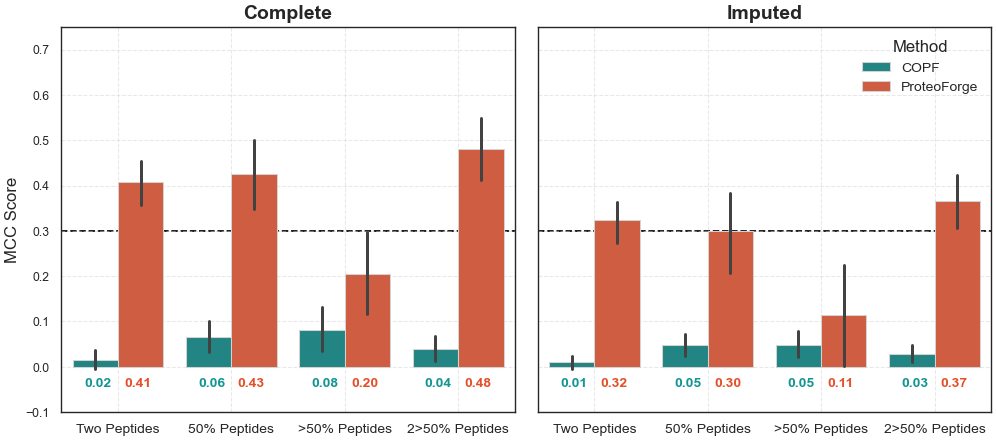

In [41]:
# MCC Score for different perturbations and methods at the best threshold

# Create subplots for MCC Score for different perturbations and methods at the best threshold
fig, axes = plt.subplots(
    1, 2, figsize=(12, 5), 
    sharey=True, sharex=True,
    gridspec_kw={"wspace": 0.05, "hspace": 0.1}
)

for i, dataType in enumerate(dataTypes):
    cur_data = grpBenchmarkData[grpBenchmarkData["DataType"] == dataType]
    sns.barplot(
        ax=axes[i],
        data=cur_data,
        x="Experiment",
        y="MCC",
        hue="Method",
        # errorbar=('se', 0.95),
        palette=method_palette,
        edgecolor="lightgrey",
        linewidth=0.75,
    )
    # Write the average MCC score for each method on the top of the bars
    for j, pert in enumerate(grpBenchmarkData['Experiment'].unique()):
        for k, method in enumerate(["COPF", "ProteoForge"]):
            cur_score = cur_data[
                (cur_data["Experiment"] == pert) & 
                (cur_data["Method"] == method)
            ]["MCC"].mean()
            axes[i].text(
                j + k * 0.35 - 0.175,
                -0.05,
                f"{cur_score:.2f}",
                color=method_palette[method],
                ha="center",
                va="bottom",
                fontsize=10,
                fontweight="bold",
            )

            
    axes[i].set_title(f"{dataType.capitalize()}", fontsize=14, fontweight="bold")
    axes[i].set_xlabel('')
    axes[i].set_ylim(-0.1, .75)
    axes[i].axhline(0.3, color="black", linestyle="--", linewidth=1.25, zorder=0)
    axes[i].grid("y", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=0, ha="center", fontsize=10)
    # If first subplot, set the ylabel
    if i == 0:
        axes[i].set_ylabel("MCC Score", fontsize=12)
        # Remove the legend for the first subplot
        axes[i].legend().set_visible(False)

    else:
        axes[i].set_ylabel("")
        axes[i].legend(loc='upper right', title="Method", fontsize=10, title_fontsize=12, frameon=False)

plt.tight_layout()

# Save the figure, if save_to_folder is True
if save_to_folder:
    plots.save_figures(
        fig_obj=plt.gcf(),
        filename=f"GroupingBenchmark_MCCBarplot",
        filepath=figure_path,
        fileformat=figure_formats,
        dpi=figure_dpi,
        transparent=transparet_bg
    )